In [1]:
cd /Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/3D printing

/Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/3D printing


In [2]:
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPyOpt
import GPy

import os

import matplotlib as mpl
import matplotlib.tri as tri

import ternary
import pickle
import datetime

from collections import Counter
import matplotlib.ticker as ticker

import pyDOE
import random
from scipy.stats import norm

from sklearn.ensemble import RandomForestRegressor

In [3]:
dataset = pd.read_csv(r'/Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/3D printing/parameterspace.csv')
X = dataset.iloc[:,0:5]
X

,n,theta,r,t,toughness
0,6,0,1.5,0.70,1.144667
1,6,0,1.5,1.05,1.607561
2,6,0,1.5,1.40,1.144338
3,6,0,1.7,0.70,3.642738
4,6,0,1.7,1.05,3.748405
...,...,...,...,...,...
1795,12,200,2.3,1.05,1.358975
1796,12,200,2.3,1.40,3.196306
1797,12,200,2.5,0.70,36.104187
1798,12,200,2.5,1.05,1.313487


In [4]:
# i put negative sign here because default BO is for minimization
X['toughness'] = -dataset.iloc[:,5].values

In [5]:
X_run = X.groupby(['n', 'theta','r','t'])['toughness'].agg(lambda x: x.unique().mean())
X_run = (X_run.to_frame()).reset_index()
X_run

,n,theta,r,t,toughness
0,6,0,1.5,0.70,-1.682633
1,6,0,1.5,1.05,-1.893500
2,6,0,1.5,1.40,-2.010900
3,6,0,1.7,0.70,-1.939033
4,6,0,1.7,1.05,-2.207833
...,...,...,...,...,...
595,12,200,2.3,1.05,-6.007200
596,12,200,2.3,1.40,-6.253133
597,12,200,2.5,0.70,-5.150967
598,12,200,2.5,1.05,-6.584467


In [6]:
features = ['n', 'theta','r','t']
X_feature = X_run[['n', 'theta','r','t']].values

y = np.array(X_run['toughness'].values)

raw_mean = np.mean(y)
raw_std = np.std(y)

In [7]:
y = (y - raw_mean) / raw_std

In [8]:
n_initial = 2
n_test = int(math.ceil(len(y) * 0.80))
n_top = int(math.ceil(len(y) * 0.05))

top_indices = list(X_run.sort_values('toughness').head(n_top).index)

In [9]:
top_indices

[599,
 581,
 598,
 566,
 449,
 596,
 595,
 431,
 593,
 533,
 578,
 446,
 416,
 580,
 565,
 575,
 560,
 548,
 590,
 299,
 577,
 413,
 445,
 443,
 562,
 592,
 448,
 545,
 563,
 415]

In [10]:
nsteps = len(y)
nsteps

600

In [11]:
x_GP_EI1_M52 = np.load('STANDARD_GP_EI_master_1to25.npy', allow_pickle = True)
x_GP_EI2_M52 = np.load('STANDARD_GP_EI_master_26to50.npy', allow_pickle = True)
x_GP_EI_M52 = [np.append(x_GP_EI1_M52[i][:25], x_GP_EI2_M52[i]) for i in np.arange(5)]

x_GP_EI1_M32 = np.load('STANDARD_GP_EI_Matern32_master_1388to3416.npy', allow_pickle = True)
x_GP_EI2_M32 = np.load('STANDARD_GP_EI_Matern32_master_3927to9841.npy', allow_pickle = True)
x_GP_EI3_M32 = np.load('STANDARD_GP_EI_Matern32_master_5to5329.npy', allow_pickle = True)
x_GP_EI4_M32 = np.load('STANDARD_GP_EI_Matern32_master_Seed9873and7748.npy', allow_pickle = True)
x_GP_EI_M32_inter1 = [np.append(x_GP_EI1_M32[i], x_GP_EI2_M32[i]) for i in np.arange(5)]
x_GP_EI_M32_inter2 = [np.append(x_GP_EI_M32_inter1[i], x_GP_EI3_M32[i]) for i in np.arange(5)]
x_GP_EI_M32 = [np.append(x_GP_EI_M32_inter2[i], x_GP_EI4_M32[i]) for i in np.arange(5)]

x_GP_EI1_M12 = np.load('STANDARD_GP_EI_Matern12_master_v1.npy', allow_pickle = True)
x_GP_EI2_M12 = np.load('STANDARD_GP_EI_Matern12_master_v2.npy', allow_pickle = True)
x_GP_EI_M12 = [np.append(x_GP_EI1_M12[i], x_GP_EI2_M12[i]) for i in np.arange(5)]

x_GP_EI_MLP = np.load('STANDARD_GP_EI_RBF_master_v1.npy', allow_pickle = True)
x_GP_EI_RBF = np.load('STANDARD_GP_EI_RBF_master_v1.npy', allow_pickle = True)


x_GP_LCB11_M52 = np.load('STANDARD_GP_LCB11_master.npy', allow_pickle = True)

x_GP_LCB111_M32 = np.load('STANDARD_GP_LCB11_Matern32_master_1388to3416.npy', allow_pickle = True)
x_GP_LCB112_M32 = np.load('STANDARD_GP_LCB11_Matern32_master_3927to9841.npy', allow_pickle = True)
x_GP_LCB113_M32 = np.load('STANDARD_GP_LCB11_Matern32_master_5to5329.npy', allow_pickle = True)
x_GP_LCB114_M32 = np.load('STANDARD_GP_LCB11_Matern32_master_Seeds9873and7748.npy', allow_pickle = True)
x_GP_LCB11_M32_inter1 = [np.append(x_GP_LCB111_M32[i], x_GP_LCB112_M32[i]) for i in np.arange(5)]
x_GP_LCB11_M32_inter2 = [np.append(x_GP_LCB11_M32_inter1[i], x_GP_LCB113_M32[i]) for i in np.arange(5)]
x_GP_LCB11_M32 = [np.append(x_GP_LCB11_M32_inter2[i], x_GP_LCB114_M32[i]) for i in np.arange(5)]

x_GP_LCB111_M12 = np.load('STANDARD_GP_LCB11_Matern12_master_v1.npy', allow_pickle = True)
x_GP_LCB112_M12 = np.load('STANDARD_GP_LCB11_Matern12_master_v2.npy', allow_pickle = True)
x_GP_LCB11_M12 = [np.append(x_GP_LCB111_M12[i], x_GP_LCB112_M12[i]) for i in np.arange(5)]

x_GP_LCB11_MLP = np.load('STANDARD_GP_LCB11_RBF_master_v1.npy', allow_pickle = True)
x_GP_LCB11_RBF = np.load('STANDARD_GP_LCB11_RBF_master_v1.npy', allow_pickle = True)


x_RF_LCB11 = np.load('STANDARD_RF_LCB11_master.npy', allow_pickle = True)
x_RF_LCB10 = np.load('STANDARD_RF_LCB10_master.npy', allow_pickle = True)
x_RF_LCB01 = np.load('STANDARD_RF_LCB01_master.npy', allow_pickle = True)
x_RF_LCB7525 = np.load('STANDARD_RF_LCB7525_master.npy', allow_pickle = True)
x_RF_EI = np.load('STANDARD_RF_EI_master.npy', allow_pickle = True)




In [12]:
def ALM_de(x):
#     rows
    n_runs = len(x)
#     columns
#     n_eval = int(np.round(len(x[0])*0.8))
    n_eval = len(x[0])
    
    
    l_f = []
    
    for i in np.arange(n_runs):
        i_row = x[i]
        
        
        f_ = []
    
        y_best = 10**15
        list_f = []
        for j in np.arange(n_eval):
            y_thisround = i_row[j]

            f = np.sum(y_thisround <= np.array(i_row[j+1:])) / len(np.array(i_row[j+1:]))
            f_.append(f)
            y_best = min(y_thisround, y_best)
#         print(f_)        
        l_f.append(f_)
    
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    six_ = [None for i in np.arange(n_eval)]
    nintyfour_ = [None for i in np.arange(n_eval)]
    
    l_f =  np.array(l_f)
    for j in np.arange(n_eval):
        j_column = l_f[:,j]
        
        mean_[j] = np.mean(j_column)
        median_[j] = np.median(j_column)
        std_[j] = np.std(j_column)
        six_[j] = np.quantile(j_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        nintyfour_[j] = np.quantile(j_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
    
    mean_ = 2*np.array(mean_) - 1
    std_ = 2*np.array(std_) - 1
    median_ = 2*np.array(median_) - 1
    six_ = 2*np.array(six_) - 1
    nintyfour_ = 2*np.array(nintyfour_) - 1
    return np.array(mean_), np.array(std_), np.array(median_), np.array(six_), np.array(nintyfour_)
        

    

In [13]:
ALM_de_GP_EI_M52 = ALM_de(x_GP_EI_M52[2])
ALM_de_GP_LCB11_M52 = ALM_de(x_GP_LCB11_M52[2])

ALM_de_GP_EI_M32 = ALM_de(x_GP_EI_M32[2])
ALM_de_GP_LCB11_M32 = ALM_de(x_GP_LCB11_M32[2])

ALM_de_GP_EI_M12 = ALM_de(x_GP_EI_M12[2])
ALM_de_GP_LCB11_M12 = ALM_de(x_GP_LCB11_M12[2])

ALM_de_GP_EI_MLP = ALM_de(x_GP_EI_MLP[2])
ALM_de_GP_LCB11_MLP = ALM_de(x_GP_LCB11_MLP[2])

ALM_de_GP_EI_RBF = ALM_de(x_GP_EI_RBF[2])
ALM_de_GP_LCB11_RBF = ALM_de(x_GP_LCB11_RBF[2])

ALM_de_RF_EI = ALM_de(x_RF_EI[2])
ALM_de_RF_LCB11 = ALM_de(x_RF_LCB11[2])

ALM_de_RF_LCB10 = ALM_de(x_RF_LCB10[2])
ALM_de_RF_LCB01 = ALM_de(x_RF_LCB01[2])
ALM_de_RF_LCB7525 = ALM_de(x_RF_LCB7525[2])

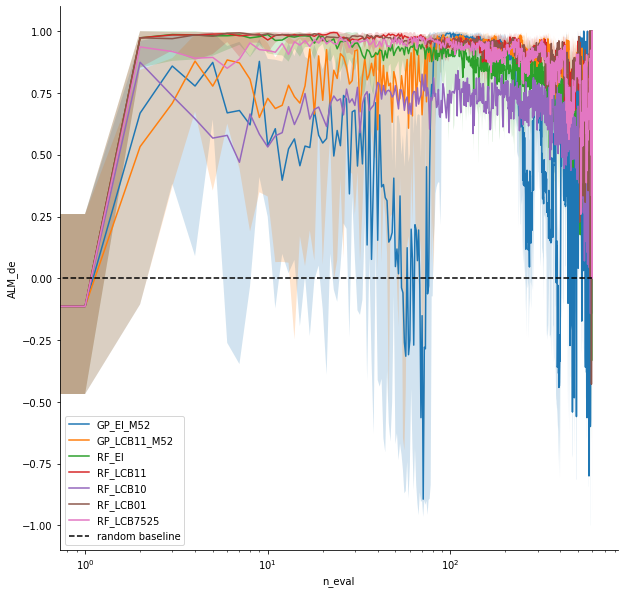

In [14]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


ax0.plot(ALM_de_GP_EI_M52[2], label = 'GP_EI_M52')
ax0.fill_between(np.arange(len(ALM_de_GP_EI_M52[2])), ALM_de_GP_EI_M52[3], ALM_de_GP_EI_M52[4], alpha=0.2)

ax0.plot(ALM_de_GP_LCB11_M52[2], label = 'GP_LCB11_M52')
ax0.fill_between(np.arange(len(ALM_de_GP_LCB11_M52[2])), ALM_de_GP_LCB11_M52[3], ALM_de_GP_LCB11_M52[4], alpha=0.2)

# ax0.plot(ALM_de_GP_EI_M32[2], label = 'GP_EI_M32')
# ax0.fill_between(np.arange(len(ALM_de_GP_EI_M32[2])), ALM_de_GP_EI_M32[3], ALM_de_GP_EI_M32[4], alpha=0.2)

# ax0.plot(ALM_de_GP_LCB11_M32[2], label = 'GP_LCB11_M32')
# ax0.fill_between(np.arange(len(ALM_de_GP_LCB11_M32[2])), ALM_de_GP_LCB11_M32[3], ALM_de_GP_LCB11_M32[4], alpha=0.2)

# ax0.plot(ALM_de_GP_EI_M12[2], label = 'GP_EI_M12')
# ax0.fill_between(np.arange(len(ALM_de_GP_EI_M12[2])), ALM_de_GP_EI_M12[3], ALM_de_GP_EI_M12[4], alpha=0.2)

# ax0.plot(ALM_de_GP_LCB11_M12[2], label = 'GP_LCB11_M12')
# ax0.fill_between(np.arange(len(ALM_de_GP_LCB11_M12[2])), ALM_de_GP_LCB11_M12[3], ALM_de_GP_LCB11_M12[4], alpha=0.2)

# ax0.plot(ALM_de_GP_EI_MLP[2], label = 'GP_EI_MLP')
# ax0.fill_between(np.arange(len(ALM_de_GP_EI_MLP[2])), ALM_de_GP_EI_MLP[3], ALM_de_GP_EI_MLP[4], alpha=0.2)

# ax0.plot(ALM_de_GP_LCB11_MLP[2], label = 'GP_LCB11_MLP')
# ax0.fill_between(np.arange(len(ALM_de_GP_LCB11_MLP[2])), ALM_de_GP_LCB11_MLP[3], ALM_de_GP_LCB11_MLP[4], alpha=0.2)

# ax0.plot(ALM_de_GP_EI_RBF[2], label = 'GP_EI_RBF')
# ax0.fill_between(np.arange(len(ALM_de_GP_EI_RBF[2])), ALM_de_GP_EI_RBF[3], ALM_de_GP_EI_RBF[4], alpha=0.2)

# ax0.plot(ALM_de_GP_LCB11_RBF[2], label = 'GP_LCB11_RBF')
# ax0.fill_between(np.arange(len(ALM_de_GP_LCB11_RBF[2])), ALM_de_GP_LCB11_RBF[3], ALM_de_GP_LCB11_RBF[4], alpha=0.2)


ax0.plot(ALM_de_RF_EI[2], label = 'RF_EI')
ax0.fill_between(np.arange(len(ALM_de_RF_EI[2])), ALM_de_RF_EI[3], ALM_de_RF_EI[4], alpha=0.2)

ax0.plot(ALM_de_RF_LCB11[2], label = 'RF_LCB11')
ax0.fill_between(np.arange(len(ALM_de_RF_LCB11[2])), ALM_de_RF_LCB11[3], ALM_de_RF_LCB11[4], alpha=0.2)


ax0.plot(ALM_de_RF_LCB10[2], label = 'RF_LCB10')
ax0.plot(ALM_de_RF_LCB01[2], label = 'RF_LCB01')
ax0.plot(ALM_de_RF_LCB7525[2], label = 'RF_LCB7525')


ax0.plot(np.linspace(0, nsteps-1, nsteps), np.zeros(nsteps),'--',color='black',label='random baseline')

ax0.legend()
ax0.set_xscale('log')
ax0.set_ylabel('ALM_de')
ax0.set_xlabel('n_eval')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

In [15]:
ALM_de_RF_LCB11[2]

array([-0.07679466, -0.11371237,  0.97319933,  0.98489933,  0.98487395,
        0.98821549,  0.98988196,  0.98141892,  0.98477157,  0.98813559,
        0.96434635,  0.9829932 ,  0.98637138,  0.98122867,  0.98632479,
        0.98287671,  0.98627787,  0.9862543 ,  0.97934596,  0.98965517,
        0.98445596,  0.98615917,  0.99306759,  0.99479167,  0.99304348,
        0.97212544,  0.97556719,  0.97202797,  0.95971979,  0.96842105,
        0.96485062,  0.96302817,  0.96825397,  0.97349823,  0.96814159,
        0.97695035,  0.96980462,  0.98042705,  0.96256684,  0.97857143,
        0.97853309,  0.97491039,  0.97666068,  0.98561151,  0.97837838,
        0.98194946,  0.98915009,  0.98369565,  0.98729583,  0.98545455,
        0.97996357,  0.98175182,  0.98903108,  0.97802198,  0.98899083,
        0.96875   ,  0.98158379,  0.97785978,  0.97597043,  0.97407407,
        0.96474954,  0.97583643,  0.97020484,  0.97761194,  0.97757009,
        0.97191011,  0.97748593,  0.97368421,  0.98116761,  0.98

In [16]:
# http://www.rsc.org/suppdata/c9/sc/c9sc05999g/c9sc05999g1.pdf
def P_rand(nn):
    x_random = np.arange(nn)
    
    M = n_top
    N = nn
    
    P = np.array([None for i in x_random])
    E = np.array([None for i in x_random])
    A = np.array([None for i in x_random])
    cA = np.array([None for i in x_random])
    
    P[0] = M / N
    E[0] = M / N
    A[0] = M / N
    cA[0] = A[0]
    

    for i in x_random[1:]:
        P[i] = (M - E[i-1]) / (N - i)
        E[i] = np.sum(P[:(i+1)])
        j = 0
        A_i = P[i]
        while j < i:
            A_i *= (1 - P[j])
            j+=1
        A[i] = A_i
        cA[i] = np.sum(A[:(i+1)])
        
#     print(A)
        
    return E / M, cA

In [17]:
seed_list = [5782, 5776, 9975, 4569, 8020, 363, 9656, 992, 348, 6048, 4114, 7476, 4892, 9710, 9854, 5243, 
             2906, 5963, 3035, 5122, 9758, 4327, 4921, 6179, 1718, 441, 9326, 2153, 5079, 8192, 3646, 4413, 
             3910, 5370, 3070, 7130, 1589, 1668, 9842, 5275, 5468, 3677, 7183, 2773, 1309, 5516, 3572, 9312, 
             7390, 4433, 3686, 1981, 555, 8677, 3126, 5163, 9418, 3007, 4564, 5572, 1401, 5657, 9658, 2124, 
             6902, 4783, 8493, 4442, 7613, 5674, 6830, 4757, 6877, 9311, 6709, 582, 6770, 2555, 3269, 76, 
             7820, 8358, 7116, 9156, 3638, 529, 7482, 8503, 4735, 8910, 5588, 3726, 1115, 9644, 4702, 1966, 
             4006, 738, 575, 8393]

def aggregation_(seed, n_runs, n_fold):
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
    random.seed(seed)
    
    index_runs = list(np.arange(n_runs))
    
    agg_list = []
    
    i = 0
    
    while i < n_fold:
    
        index_i = random.sample(index_runs, fold_size)
        for j in index_i:
            index_runs.remove(j)
            
        agg_list.append(index_i)
        
        i += 1
#     print(agg_list)    
    return agg_list



In [18]:
def avg_(x):
#     nsteps
    n_eval = len(x[0]) 
    
#     fold
    n_fold = 5
    
#     rows = # of ensembles = 50
    n_runs = len(x)
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
#     # of seeds 
    n_sets = len(seed_list)
    
    l_index_list = []
    
    for i in np.arange(n_sets):
        
        s = aggregation_(seed_list[i], n_runs, n_fold)
        l_index_list.extend(s)

#     rows in l_index_list

    assert len(l_index_list) == n_sets * n_fold
    

    
    l_avg_runs = []

    for i in np.arange(len(l_index_list)):
        
        avg_run = np.zeros(n_eval)
        for j in l_index_list[i]:
            
            avg_run += np.array(x[j])
            
        avg_run = avg_run/fold_size
        l_avg_runs.append(avg_run)
    

    assert n_eval == len(l_avg_runs[0])
    assert n_sets * n_fold == len(l_avg_runs)
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    

    
    for i in np.arange(len(l_avg_runs[0])):
        i_column = []
        for j in np.arange(len(l_avg_runs)):
            i_column.append(l_avg_runs[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
    
    return np.array(median_), np.array(low_q), np.array(high_q)



In [19]:
def ALM_all(x):
    
    n_eval = len(x[0])
    
    x_ = [[] for i in np.arange(len(x))]
    
    for j in np.arange(len(x)):
        for i in np.arange(n_eval):
            x_[j].append(x[j][i] / n_top)
        
    return x_

In [20]:
# [index_collection, X_collection, y_collection, TopPercent_collection, MAE_collection]

TopPercent = 3

i_ = TopPercent

ALM_all_GP_LCB11_M52 = avg_(ALM_all(x_GP_LCB11_M52[i_]))
ALM_all_GP_EI_M52 = avg_(ALM_all(x_GP_EI_M52[i_]))


ALM_all_RF_LCB11 = avg_(ALM_all(x_RF_LCB11[i_]))
ALM_all_RF_EI = avg_(ALM_all(x_RF_EI[i_]))

                        
ALM_all_RF_LCB10 = avg_(ALM_all(x_RF_LCB10[i_]))
ALM_all_RF_LCB01 = avg_(ALM_all(x_RF_LCB01[i_]))
ALM_all_RF_LCB7525 = avg_(ALM_all(x_RF_LCB7525[i_]))



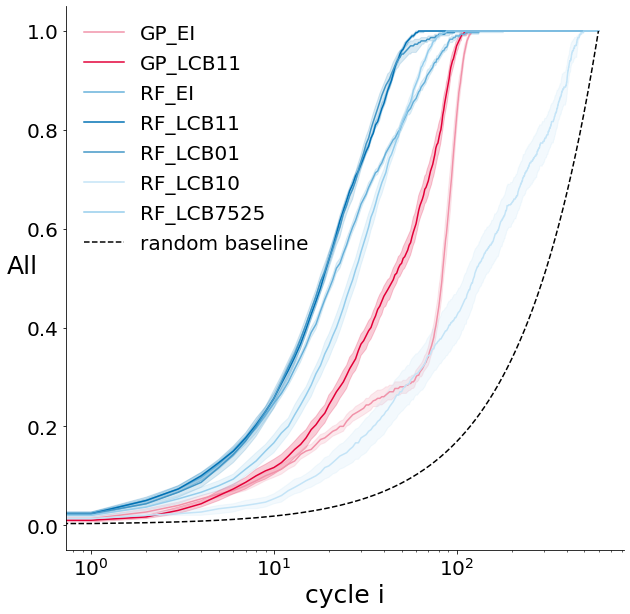

In [28]:
# np.array(median_), np.array(low_q), np.array(high_q)


fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(ALM_all_GP_EI_M52[0], label = 'GP_EI', color = '#F192A9')
ax0.fill_between(np.arange(len(ALM_all_GP_EI_M52[0])), ALM_all_GP_EI_M52[1], ALM_all_GP_EI_M52[2], alpha=0.2, color = '#F192A9')

ax0.plot(ALM_all_GP_LCB11_M52[0], label = 'GP_LCB11', color = '#E30038')
ax0.fill_between(np.arange(len(ALM_all_GP_LCB11_M52[0])), ALM_all_GP_LCB11_M52[1], ALM_all_GP_LCB11_M52[2], alpha=0.2, color = '#E30038')


ax0.plot(ALM_all_RF_EI[0], label = 'RF_EI', color = '#67B1DA')
ax0.fill_between(np.arange(len(ALM_all_RF_EI[0])), ALM_all_RF_EI[1], ALM_all_RF_EI[2], alpha=0.2, color = '#67B1DA')

ax0.plot(ALM_all_RF_LCB11[0], label = 'RF_LCB11', color = '#0071B4')
ax0.fill_between(np.arange(len(ALM_all_RF_LCB11[0])), ALM_all_RF_LCB11[1], ALM_all_RF_LCB11[2], alpha=0.2, color = '#0071B4')


ax0.plot(ALM_all_RF_LCB01[0], label = 'RF_LCB01', color = '#4196C6')
ax0.fill_between(np.arange(len(ALM_all_RF_LCB01[0])), ALM_all_RF_LCB01[1], ALM_all_RF_LCB01[2], alpha=0.2, color = '#4196C6')

ax0.plot(ALM_all_RF_LCB10[0], label = 'RF_LCB10', color = '#C4E4F7')
ax0.fill_between(np.arange(len(ALM_all_RF_LCB10[0])), ALM_all_RF_LCB10[1], ALM_all_RF_LCB10[2], alpha=0.2, color = '#C4E4F7')

ax0.plot(ALM_all_RF_LCB7525[0], label = 'RF_LCB7525', color = '#95CDEC')
ax0.fill_between(np.arange(len(ALM_all_RF_LCB7525[0])), ALM_all_RF_LCB7525[1], ALM_all_RF_LCB7525[2], alpha=0.2, color = '#95CDEC')




ax0.plot(np.arange(len(ALM_all_RF_LCB11[0])), P_rand(len(ALM_all_RF_LCB11[0]))[0],'--',color='black',label='random baseline')

ax0.legend(fontsize = 20, frameon=False)
# ax0.set_ylabel('loss')
ax0.set_xlabel('n_eval')
# ax0.set_title('median')
# ax0.set_xlim([0, 500])
# ax0.set_ylim([0, 2])
ax0.set_xscale('log')
ax0.set_ylabel('All', fontsize=25, rotation='horizontal')
ax0.set_xlabel('cycle i', fontsize=25)

ax0.xaxis.set_tick_params(labelsize=20)
ax0.yaxis.set_tick_params(labelsize=20)


ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)



In [30]:
def EF(x):
    
    n_eval = len(x)

    ALM_ALL_RS = P_rand(n_eval)[0]
    
    l_EF = []
    
    for j in np.arange(n_eval):
        l_EF.append(x[j] / ALM_ALL_RS[j])
        
    return l_EF
  

def AF(x):
    
    n_eval = len(x)

#     ALM_RS = P_rand(n_eval)[0]
    ALM_RS = list(np.round(P_rand(len(ALM_all_RF_LCB11[0]))[0].astype(np.double) / 0.005, 0) * 0.005)
    l_ALM = []
    l_AF = []
    
    x = list(np.round(x.astype(np.double) / 0.005, 0) * 0.005)
    
    ALM_linspace = np.arange(0, 1.005, 0.005)
#     print(len(ALM_RS))
#     print(len(x))
    
    pointer_x = 0
    pointer_rs = 0
    for t in ALM_linspace:
        if t in x and t in ALM_RS:
            n_x = 0
            n_rs = 0
            while pointer_x < len(x):
                if x[pointer_x] == t:
                    pointer_x += 1
                    n_x = pointer_x
                    break
                else:
                    pointer_x += 1

            while pointer_rs < len(ALM_RS):
                if ALM_RS[pointer_rs] == t:
                    pointer_rs += 1
                    n_rs = pointer_rs
                    break
                else:
                    pointer_rs += 1
        
            l_ALM.append(t)
#             print(t, n_rs, n_x)
            AF = n_rs / n_x
            l_AF.append(AF)  
        
    return l_ALM, l_AF                                 




In [31]:
from scipy.interpolate import splrep

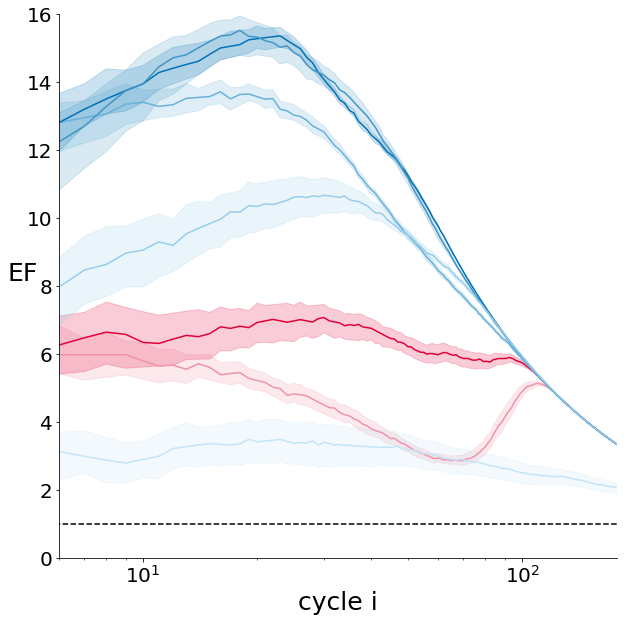

In [35]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(EF(ALM_all_GP_EI_M52[0]), label = 'GP_EI_M52', color = '#F192A9')
ax0.fill_between(np.arange(len(EF(ALM_all_GP_EI_M52[0]))), EF(ALM_all_GP_EI_M52[1]), EF(ALM_all_GP_EI_M52[2]), alpha=0.2, color = '#F192A9')

ax0.plot(EF(ALM_all_GP_LCB11_M52[0]), label = 'GP_LCB11_M52', color = '#E30038')
ax0.fill_between(np.arange(len(EF(ALM_all_GP_LCB11_M52[0]))), EF(ALM_all_GP_LCB11_M52[1]), EF(ALM_all_GP_LCB11_M52[2]), alpha=0.2, color = '#E30038')

ax0.plot(EF(ALM_all_RF_EI[0]), label = 'RF_EI', color = '#67B1DA')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_EI[0]))), EF(ALM_all_RF_EI[1]), EF(ALM_all_RF_EI[2]), alpha=0.2, color = '#67B1DA')

ax0.plot(EF(ALM_all_RF_LCB11[0]), label = 'RF_LCB11', color = '#0071B4')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB11[0]))), EF(ALM_all_RF_LCB11[1]), EF(ALM_all_RF_LCB11[2]), alpha=0.2, color = '#0071B4')

ax0.plot(EF(ALM_all_RF_LCB01[0]), label = 'RF_LCB01', color = '#4196C6')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB01[0]))), EF(ALM_all_RF_LCB01[1]), EF(ALM_all_RF_LCB01[2]), alpha=0.2, color = '#4196C6')

ax0.plot(EF(ALM_all_RF_LCB10[0]), label = 'RF_LCB10', color = '#C4E4F7')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB10[0]))), EF(ALM_all_RF_LCB10[1]), EF(ALM_all_RF_LCB10[2]), alpha=0.2, color = '#C4E4F7')

ax0.plot(EF(ALM_all_RF_LCB7525[0]), label = 'RF_LCB7525', color = '#95CDEC')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB7525[0]))), EF(ALM_all_RF_LCB7525[1]), EF(ALM_all_RF_LCB7525[2]), alpha=0.2, color = '#95CDEC')


ax0.plot(np.linspace(0, nsteps-1, nsteps), np.ones(nsteps),'--',color='black',label='random baseline')        

# ax0.legend()
ax0.set_ylabel('EF', fontsize=25, rotation = 'horizontal')
ax0.tick_params(axis='y', labelsize=12)

ax0.set_xlabel('cycle i', fontsize=25)
ax0.tick_params(axis='x', labelsize=12)
# ax0.set_title('median')
ax0.set_xlim([6, 178])
ax0.set_ylim([0, 16])
ax0.set_xscale('log')
# ax0.set_yscale('log')

ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax0.xaxis.set_tick_params(labelsize=20)
ax0.yaxis.set_tick_params(labelsize=20)
        
    

In [38]:
from scipy.interpolate import interp1d

In [39]:
def AF_interp1d(ALM_all):
    f_med = interp1d(AF(ALM_all[0])[0], AF(ALM_all[0])[1], kind = 'linear', fill_value='extrapolate')
    xx_ = np.linspace(min(AF(ALM_all[0])[0]), 1, 201 - int(min(AF(ALM_all[0])[0])/0.005))
    f_low = interp1d(AF(ALM_all[1])[0], AF(ALM_all[1])[1], kind = 'linear', fill_value='extrapolate')
    f_high = interp1d(AF(ALM_all[2])[0], AF(ALM_all[2])[1], kind = 'linear', fill_value='extrapolate')   
    return xx_, f_med, f_low, f_high

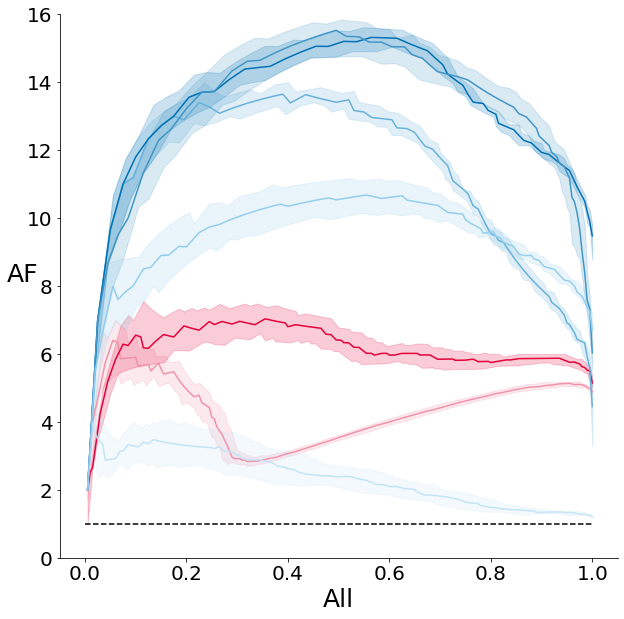

In [41]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


xx_GP_EI_M52, f_med_GP_EI_M52, f_low_GP_EI_M52, f_high_GP_EI_M52 = AF_interp1d(ALM_all_GP_EI_M52)
ax0.plot(xx_GP_EI_M52, f_med_GP_EI_M52(xx_GP_EI_M52), label = 'GP_EI_M52', color = '#F192A9')
ax0.fill_between(xx_GP_EI_M52, f_low_GP_EI_M52(xx_GP_EI_M52), f_high_GP_EI_M52(xx_GP_EI_M52), alpha=0.2, color = '#F192A9')

xx_GP_LCB11_M52, f_med_GP_LCB11_M52, f_low_GP_LCB11_M52, f_high_GP_LCB11_M52 = AF_interp1d(ALM_all_GP_LCB11_M52)
ax0.plot(xx_GP_LCB11_M52, f_med_GP_LCB11_M52(xx_GP_LCB11_M52), label = 'GP_LCB11_M52', color = '#E30038')
ax0.fill_between(xx_GP_LCB11_M52, f_low_GP_LCB11_M52(xx_GP_LCB11_M52), f_high_GP_LCB11_M52(xx_GP_LCB11_M52), alpha=0.2, color = '#E30038')

xx_RF_EI, f_med_RF_EI, f_low_RF_EI, f_high_RF_EI = AF_interp1d(ALM_all_RF_EI)
ax0.plot(xx_RF_EI, f_med_RF_EI(xx_RF_EI), label = 'RF_EI', color = '#67B1DA')
ax0.fill_between(xx_RF_EI, f_low_RF_EI(xx_RF_EI), f_high_RF_EI(xx_RF_EI), alpha=0.2, color = '#67B1DA')

xx_RF_LCB11, f_med_RF_LCB11, f_low_RF_LCB11, f_high_RF_LCB11 = AF_interp1d(ALM_all_RF_LCB11)
ax0.plot(xx_RF_LCB11, f_med_RF_LCB11(xx_RF_LCB11), label = 'RF_LCB11', color = '#0071B4')
ax0.fill_between(xx_RF_LCB11, f_low_RF_LCB11(xx_RF_LCB11), f_high_RF_LCB11(xx_RF_LCB11), alpha=0.2, color = '#0071B4')

xx_RF_LCB01, f_med_RF_LCB01, f_low_RF_LCB01, f_high_RF_LCB01 = AF_interp1d(ALM_all_RF_LCB01)
ax0.plot(xx_RF_LCB01, f_med_RF_LCB01(xx_RF_LCB01), label = 'RF_LCB01', color = '#4196C6')
ax0.fill_between(xx_RF_LCB01, f_low_RF_LCB01(xx_RF_LCB01), f_high_RF_LCB01(xx_RF_LCB01), alpha=0.2, color = '#4196C6')

xx_RF_LCB10, f_med_RF_LCB10, f_low_RF_LCB10, f_high_RF_LCB10 = AF_interp1d(ALM_all_RF_LCB10)
ax0.plot(xx_RF_LCB10, f_med_RF_LCB10(xx_RF_LCB10), label = 'RF_LCB10', color = '#C4E4F7')
ax0.fill_between(xx_RF_LCB10, f_low_RF_LCB10(xx_RF_LCB10), f_high_RF_LCB10(xx_RF_LCB10), alpha=0.2, color = '#C4E4F7')


xx_RF_LCB7525, f_med_RF_LCB7525, f_low_RF_LCB7525, f_high_RF_LCB7525 = AF_interp1d(ALM_all_RF_LCB7525)
ax0.plot(xx_RF_LCB7525, f_med_RF_LCB7525(xx_RF_LCB7525), label = 'RF_LCB7525', color = '#95CDEC')
ax0.fill_between(xx_RF_LCB7525, f_low_RF_LCB7525(xx_RF_LCB7525), f_high_RF_LCB7525(xx_RF_LCB7525), alpha=0.2, color = '#95CDEC')


ax0.plot(np.linspace(0, 1, 176), np.ones(176),'--',color='black',label=None)        
        

# ax0.legend()
ax0.set_ylabel('AF', fontsize = 25, rotation = 'horizontal')
ax0.set_xlabel('All', fontsize = 25)
# ax0.set_title('median')
# ax0.set_xlim([8, nn])
ax0.set_ylim([0, 16])
# ax0.set_xscale('log')
# ax0.set_yscale('log')

ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax0.xaxis.set_tick_params(labelsize=20)
ax0.yaxis.set_tick_params(labelsize=20)

In [34]:
def ALM_any(x, top_list):
    
    n_eval = len(x[0])
    
    assert n_eval > len(top_list)
    
    x_ = [[0 for m in np.arange(n_eval)] for n in np.arange(len(x))]
    
    for j in np.arange(len(x)):
        found = False
        for i in np.arange(n_eval):
            if found == False:
                if x[j][i] in top_list:
                    x_[j][i] = 1
                    found = True
                    
            else:
                x_[j][i] = 1
        
    return x_

In [35]:
# [index_collection, X_collection, y_collection, TopPercent_collection, MAE_collection]

index_ = 0

i_ = index_


ALM_any_GP_EI_M52 = avg_(ALM_any(x_GP_EI_M52[i_], top_indices))
ALM_any_GP_LCB11_M52 = avg_(ALM_any(x_GP_LCB11_M52[i_], top_indices))

ALM_any_RF_EI = avg_(ALM_any(x_RF_EI[i_], top_indices))
ALM_any_RF_LCB11 = avg_(ALM_any(x_RF_LCB11[i_], top_indices))

ALM_any_RF_LCB10 = avg_(ALM_any(x_RF_LCB10[i_], top_indices))
ALM_any_RF_LCB01 = avg_(ALM_any(x_RF_LCB01[i_], top_indices))
ALM_any_RF_LCB7525 = avg_(ALM_any(x_RF_LCB7525[i_], top_indices))

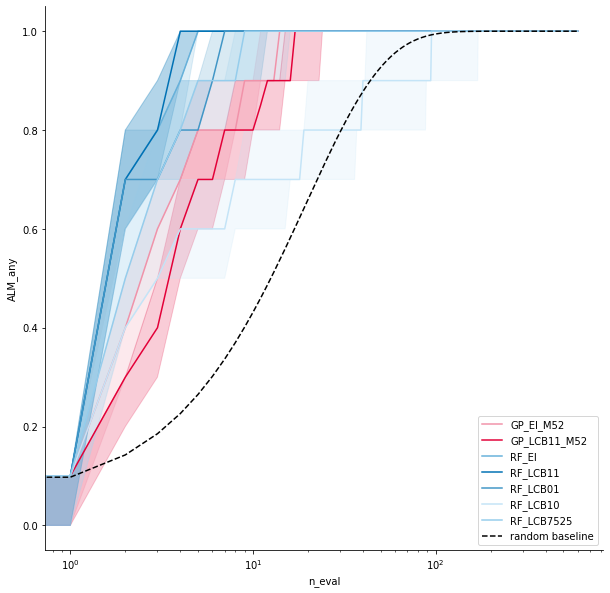

In [37]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(ALM_any_GP_EI_M52[0], label = 'GP_EI_M52', color = '#F192A9')
ax0.fill_between(np.arange(len(ALM_any_GP_EI_M52[0])), ALM_any_GP_EI_M52[1], ALM_any_GP_EI_M52[2], alpha=0.2, color = '#F192A9')

ax0.plot(ALM_any_GP_LCB11_M52[0], label = 'GP_LCB11_M52', color = '#E30038')
ax0.fill_between(np.arange(len(ALM_any_GP_LCB11_M52[0])), ALM_any_GP_LCB11_M52[1], ALM_any_GP_LCB11_M52[2], alpha=0.2, color = '#E30038')

ax0.plot(ALM_any_RF_EI[0], label = 'RF_EI', color = '#67B1DA')
ax0.fill_between(np.arange(len(ALM_any_RF_EI[0])), ALM_any_RF_EI[1], ALM_any_RF_EI[2], alpha=0.2, color = '#67B1DA')

ax0.plot(ALM_any_RF_LCB11[0], label = 'RF_LCB11', color = '#0071B4')
ax0.fill_between(np.arange(len(ALM_any_RF_LCB11[0])), ALM_any_RF_LCB11[1], ALM_any_RF_LCB11[2], alpha=0.2, color = '#0071B4')

ax0.plot(ALM_any_RF_LCB01[0], label = 'RF_LCB01', color = '#4196C6')
ax0.fill_between(np.arange(len(ALM_any_RF_LCB01[0])), ALM_any_RF_LCB01[1], ALM_any_RF_LCB01[2], alpha=0.2, color = '#4196C6')

ax0.plot(ALM_any_RF_LCB10[0], label = 'RF_LCB10', color = '#C4E4F7')
ax0.fill_between(np.arange(len(ALM_any_RF_LCB10[0])), ALM_any_RF_LCB10[1], ALM_any_RF_LCB10[2], alpha=0.2, color = '#C4E4F7')

ax0.plot(ALM_any_RF_LCB7525[0], label = 'RF_LCB7525', color = '#95CDEC')
ax0.fill_between(np.arange(len(ALM_any_RF_LCB7525[0])), ALM_any_RF_LCB7525[1], ALM_any_RF_LCB7525[2], alpha=0.2, color = '#95CDEC')
        
    
ax0.plot(np.arange(len(ALM_any_RF_LCB11[0])), P_rand(len(ALM_any_RF_LCB11[0]))[1],'--',color='black',label='random baseline')    
        

ax0.legend()
ax0.set_ylabel('ALM_any')
ax0.set_xlabel('n_eval')
# ax0.set_title('median')
# ax0.set_xlim([-10, nn+1000])
# ax0.set_ylim([0, 2])
ax0.set_xscale('log')
# ax0.set_yscale('log')


ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

In [54]:
def EF_any(x):
    
    n_eval = len(x)

    ALM_ANY_RS = P_rand(n_eval)[1]
    
    l_EF = []
    
    for j in np.arange(n_eval):
        l_EF.append(x[j] / ALM_ANY_RS[j])
        
    return l_EF
  

# def AF_any(x):
#     n_eval = len(x)

#     ALM_ANY_RS = P_rand(n_eval)[1]
    
#     l_ALM = []
#     l_AF = []
    
#     for j in np.arange(n_eval):
#         n_eval_opt = j
#         ALM = x[j]
#         l_ALM.append(ALM)
#         n_eval_rs = ALM * (n_eval - 1)
#         AF = n_eval_rs / n_eval_opt
#         l_AF.append(AF)
        
#     return l_ALM, l_AF

def AF(x):
    
    n_eval = len(x)

    ALM_RS = P_rand(n_eval)[1]
    
    l_ALM = []
    l_AF = []
    
    
    for j in np.arange(n_eval):
        ALM_j = x[j]
        n_opt = j + 1  
        l_ALM.append(ALM_j)
        
        
        delta = 10**10
        n_rs = None
        for s in np.arange(n_eval):
            if abs(ALM_j - ALM_RS[s]) < delta:
                delta = abs(ALM_j - ALM_RS[s])
                n_rs = s + 1
                
        AF = n_rs / n_opt
        l_AF.append(AF)
        
    return l_ALM, l_AF

In [55]:
ARD_ = False

Bias_kernel = GPy.kern.Bias(X_feature.shape[1], variance=1.)

Matern52_kernel = GPy.kern.Matern52(X_feature.shape[1], variance=1., ARD=ARD_) + Bias_kernel

n_est = 50

In [ ]:
def calc_MAE_GP(test_index, SL_model):
    SL_mae = 0
    
    for index in test_index:
        X_test = X_feature[index]
        y_test = y[index]
        
        X_test = X_test.reshape([1,X_feature.shape[1]])
        
        SL_mean, SL_std = SL_model.predict(X_test)[0][0][0], SL_model.predict(X_test)[1][0][0]
        
        sl_mae = (y_test - SL_mean)**2 
        SL_mae += sl_mae       
    
    return SL_mae / len(test_index)

def GP_MAE_full():
    
    seed_list = [5, 892, 91, 2345, 391, 77, 223, 8258, 16, 3, 84,7646,6207,4530,8206,6260,2342,3112,5187,2737,8979,4018,8223,1678,9481,2232,
             461,7694,6091, 3189,2480,9106,1316,8500,2531,5329,9872,1388,8805,2726,119,3416,7747,3927,138,1488,232,4564,3492,9841]
    
    total_mae = 0
    
    for s in seed_list:
        
        index_test = list(np.arange(len(y)))
        n_train = int(math.ceil(len(y) * 0.70))
    
        index_train = random.sample(index_test, n_train)
        
        X_train = []
        y_train = []
        
        for i in index_train:
            X_train.append(X_feature[i])
            y_train.append(y[i])
            index_test.remove(i)
        
        GP_train = GPy.models.GPRegression(X = np.array(X_train), 
                                           Y = np.array([[i] for i in y_train]), 
                                           kernel= Matern52_kernel,
                                           noise_var = 0.01
                                          )

        GP_train.optimize_restarts(num_restarts=10,
                                   parallel = True,
                                   robust = True,
                                   optimizer = 'bfgs',
                                   max_iters=100,
                                   verbose = False)
        
        total_mae += calc_MAE_GP(index_test, GP_train)
        
    return total_mae / len(seed_list)

def calc_MAE_RF(test_index, RF_model):
    RF_mae = 0
    for index in test_index:
        X_test = X_feature[index]
        y_test = y[index]

        tree_predictions = []
        for j in np.arange(n_est):
            tree_predictions.append((RF_model.estimators_[j].predict(np.array([X_test]))).tolist())
        mean = np.mean(np.array(tree_predictions), axis=0)[0]

        std = np.std(np.array(tree_predictions), axis=0)[0]

        mae_ = (y_test - mean)**2 
        RF_mae += mae_
        
    return RF_mae / len(test_index)

def RF_MAE_full():
    
    seed_list = [5, 892, 91, 2345, 391, 77, 223, 8258, 16, 3, 84,7646,6207,4530,8206,6260,2342,3112,5187,2737,8979,4018,8223,1678,9481,2232,
             461,7694,6091, 3189,2480,9106,1316,8500,2531,5329,9872,1388,8805,2726,119,3416,7747,3927,138,1488,232,4564,3492,9841]
    
    total_mae = 0
    
    for s in seed_list:
        
        index_test = list(np.arange(len(y)))
        n_train = int(math.ceil(len(y) * 0.70))
    
        index_train = random.sample(index_test, n_train)
        
        X_train = []
        y_train = []
        
        for i in index_train:
            X_train.append(X_feature[i])
            y_train.append(y[i])
            index_test.remove(i)
        
        RF_model = RandomForestRegressor(n_estimators= n_est)
        RF_model.fit(X_train, y_train)
        
        total_mae += calc_MAE_RF(index_test, RF_model)
        
    return total_mae / len(seed_list)

    

Text(0.5, 0, 'n_eval')

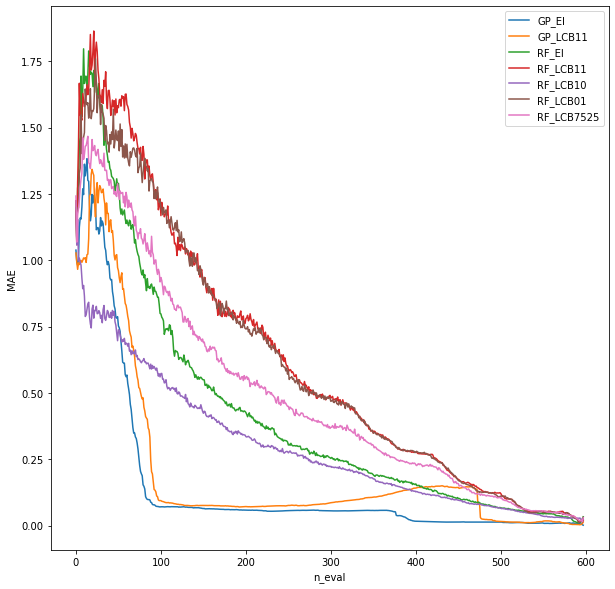

In [12]:
def average_run(x):
#     rows
    n_runs = len(x)
#     columns
    n_eval = len(x[0])
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    six_ = [None for i in np.arange(n_eval)]
    nintyfour_ = [None for i in np.arange(n_eval)]
    

    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(n_runs):
            i_column.append(x[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        six_[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        nintyfour_[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
        
        
    return np.array(median_), np.array(six_), np.array(nintyfour_)




# [index_collection, X_collection, y_collection, TopPercent_collection, MAE_collection]

MAE = 4

i_ = MAE

MAE_GP_EI = average_run(x_GP_EI[i_])
MAE_GP_LCB11 = average_run(x_GP_LCB11[i_])


MAE_RF_EI = average_run(x_RF_EI[i_])
MAE_RF_LCB11 = average_run(x_RF_LCB11[i_])

MAE_RF_LCB10 = average_run(x_RF_LCB10[i_])
MAE_RF_LCB01 = average_run(x_RF_LCB01[i_])
MAE_RF_LCB7525 = average_run(x_RF_LCB7525[i_])


fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(MAE_GP_EI[0], label = 'GP_EI')
# ax0.fill_between(np.arange(len(MAE_GP_EI[0])), MAE_GP_EI[1], MAE_GP_EI[2], alpha=0.2)

ax0.plot(MAE_GP_LCB11[0], label = 'GP_LCB11')
# ax0.fill_between(np.arange(len(MAE_GP_LCB[0])), MAE_GP_LCB[1], MAE_GP_LCB[2], alpha=0.2)


ax0.plot(MAE_RF_EI[0], label = 'RF_EI')
# # ax0.fill_between(np.arange(len(MAE_RF_EI[0])), MAE_RF_EI[1], MAE_RF_EI[2], alpha=0.2)

ax0.plot(MAE_RF_LCB11[0], label = 'RF_LCB11')
# ax0.fill_between(np.arange(len(MAE_RF_LCB11[0])), MAE_RF_LCB11[1], MAE_RF_LCB11[2], alpha=0.2)
# 
ax0.plot(MAE_RF_LCB10[0], label = 'RF_LCB10')
ax0.plot(MAE_RF_LCB01[0], label = 'RF_LCB01')
ax0.plot(MAE_RF_LCB7525[0], label = 'RF_LCB7525')
        

ax0.legend()
ax0.set_ylabel('MAE')
ax0.set_xlabel('n_eval')
# ax0.set_title('median')
# ax0.set_xlim([0, int(math.ceil(len(y)*0.70))])
# ax0.set_ylim([0, 2])
# ax0.set_xscale('log')
# ax0.set_yscale('log')

In [13]:
MAE_GP_EI[0]

array([1.03818063, 0.99330493, 0.98156932, 1.00360657, 1.12435904,
       1.15928432, 1.15528869, 1.20015247, 1.26908425, 1.24745859,
       1.36207455, 1.31801293, 1.34438789, 1.38270754, 1.30092885,
       1.29766738, 1.21043162, 1.14848247, 1.17077577, 1.24810071,
       1.21589997, 1.24433137, 1.21633358, 1.2096941 , 1.11481458,
       1.12154829, 1.12336856, 1.09864273, 1.11027548, 1.16085383,
       1.12941602, 1.1476654 , 1.13741697, 1.09221617, 1.04887221,
       1.03756672, 1.00105178, 0.98297819, 0.995018  , 0.98128834,
       0.93352238, 0.92580064, 0.9271931 , 0.88198805, 0.86153795,
       0.82830457, 0.81665359, 0.78378929, 0.78180793, 0.78734046,
       0.75257672, 0.74531677, 0.73101123, 0.69559413, 0.65849846,
       0.6158658 , 0.61271974, 0.61226635, 0.56921473, 0.561     ,
       0.56733517, 0.53544981, 0.51601222, 0.49387864, 0.45680824,
       0.43775159, 0.40462166, 0.36963405, 0.34852712, 0.34914237,
       0.33383532, 0.32812623, 0.31145228, 0.2890181 , 0.25923

In [ ]:
def EF(l_avg_runs):
    
    n_eval = len(l_avg_runs[0])

    x_random = np.linspace(0, n_eval-1, n_eval)
    ALM_ALL_RS = 1/(n_eval-1) * x_random
    
    l_EF = []
    
    for i in np.arange(len(l_avg_runs)):
        EF_i = []
        for j in np.arange(n_eval):
            EF_i.append(l_avg_runs[i][j] / ALM_ALL_RS[j])
        l_EF.append(EF_i)   
    
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_EF)):
            i_column.append(l_EF[j][i])
        
        i_column = np.array(i_column)
        median_[i] = np.median(i_column)
        low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
    
    return np.array(median_)/ n_top, np.array(low_q)/ n_top, np.array(high_q)/ n_top
  

def AF(l_avg_runs):
    n_eval = len(l_avg_runs[0])

    x_random = np.linspace(0, n_eval-1, n_eval)
    ALM_ALL_RS = 1/(n_eval-1) * x_random
    
    l_ALM = []
    l_AF = []
    
    for i in np.arange(len(l_avg_runs)):
        ALM_i = []
        AF_i = []
        for j in np.arange(n_eval):
            n_eval_opt = j
            ALM = l_avg_runs[i][j]
            ALM_i.append(ALM)
            n_eval_rs = ALM * (n_eval - 1)
            AF = n_eval_rs / n_eval_opt
            AF_i.append(AF)
        l_ALM.append(ALM_i)
        l_AF.append(AF_i)
        
    ALM_median_ = [None for i in np.arange(n_eval)]
    ALM_low_q = [None for i in np.arange(n_eval)]
    ALM_high_q = [None for i in np.arange(n_eval)]
    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_ALM)):
            i_column.append(l_ALM[j][i])

        ALM_median_[i] = np.median(i_column)
        ALM_low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        ALM_high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')   
    
    AF_median_ = [None for i in np.arange(n_eval)]
    AF_low_q = [None for i in np.arange(n_eval)]
    AF_high_q = [None for i in np.arange(n_eval)]
    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_AF)):
            i_column.append(l_AF[j][i])

        AF_median_[i] = np.median(i_column)
        AF_low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        AF_high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')   
        
    return np.array(ALM_median_)/ n_top, np.array(ALM_low_q)/ n_top, np.array(ALM_high_q)/ n_top, np.array(AF_median_)/ n_top, np.array(AF_low_q)/ n_top, np.array(AF_high_q)/ n_top